In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np



import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Import the SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import TimeSeriesSplit


# Import mean squared error for evaluation
from sklearn.metrics import mean_squared_error,mean_absolute_error

from prophet import Prophet

import plotly.express as px
import plotly.graph_objects as go

from dash import Dash, dcc, html, Input, Output
import dash_bootstrap_components as dbc

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor



# Ensure that matplotlib plots display inline
%matplotlib inline
# Optional: Set plot styles for better aesthetics
sns.set(style='whitegrid')

In [32]:
# Load the dataset
# Replace 'sales_data.csv' with your actual file path or filename
df = pd.read_csv('./data/ventes_luxe_détaillées.csv', sep=';')

# Display the first few rows of the dataset
df.head()

df_daily_sales = df.groupby('Date')['Montant_Ventes'].sum().reset_index()


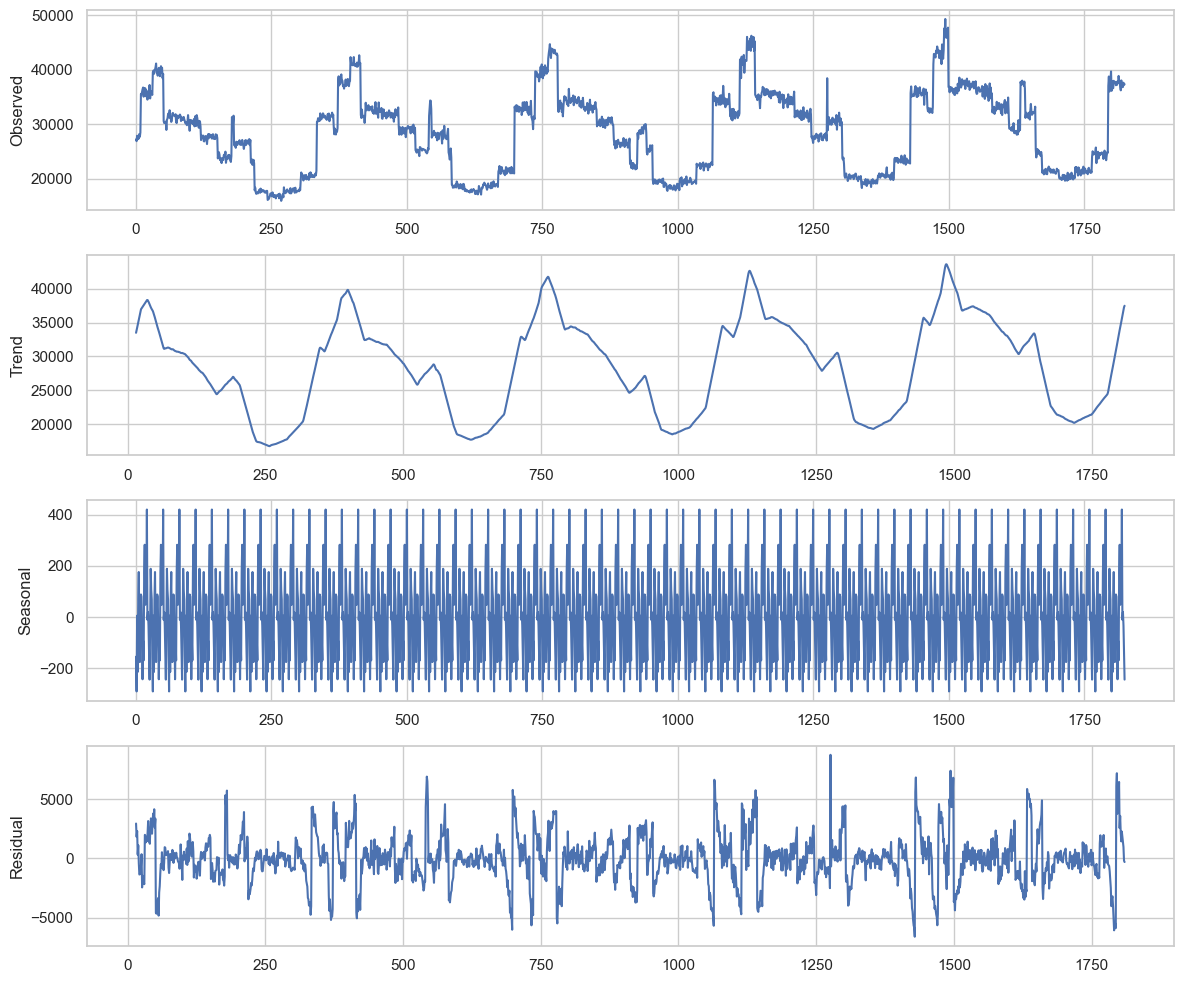

In [33]:

# Décomposition additive
decomposition = seasonal_decompose(df_daily_sales['Montant_Ventes'], model='additive', period=30)

# Visualisation de la décomposition
# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))

decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

In [ ]:
# Prepare the data for Prophet
df_prophet = df_daily_sales.rename(columns={'Date': 'ds', 'Montant_Ventes': 'y'})

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])


# Handle 'Événement_Spécial' if it exists
if 'Événement_Spécial' in df.columns:
    # Merge 'Événement_Spécial' into df_prophet
    event_data = df[['Date', 'Événement_Spécial']].drop_duplicates()
    event_data = event_data.rename(columns={'Date': 'ds'})
    df_prophet = df_prophet.merge(event_data, on='ds', how='left')
    
    # Fill missing 'Événement_Spécial' values
    df_prophet['Événement_Spécial'] = df_prophet['Événement_Spécial'].fillna('None')
    
    # Convert categorical events to dummy variables
    df_prophet = pd.get_dummies(df_prophet, columns=['Événement_Spécial'])
    
    # Get the list of event regressor columns
    event_regressors = [col for col in df_prophet.columns if col.startswith('Événement_Spécial_')]
else:
    event_regressors = []

# # Log transformation to stabilize variance
# df_prophet['y'] = np.log(df_prophet['y'] + 1)

# # Create the Prophet model with adjusted hyperparameters
# model = Prophet(
#     changepoint_prior_scale=0.1,    # Controls trend flexibility
#     seasonality_prior_scale=15.0,   # Controls seasonality strength
#     seasonality_mode='multiplicative'  # Use multiplicative seasonality if appropriate
# )

# # Add custom seasonalities
# model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
# model.add_seasonality(name='weekly', period=7, fourier_order=3)

# # Add regressors to the model
# for regressor in event_regressors:
#     model.add_regressor(regressor)

# # Fit the model
# model.fit(df_prophet)

# # Create future dataframe for predictions
# future = model.make_future_dataframe(periods=30)  # Forecasting 30 days into the future

# # Prepare future dataframe with regressors
# if event_regressors:
#     # Merge event data into future dataframe
#     future = future.merge(event_data, on='ds', how='left')
#     future['Événement_Spécial'] = future['Événement_Spécial'].fillna('None')
#     # Convert to dummy variables
#     future = pd.get_dummies(future, columns=['Événement_Spécial'])
#     # Ensure all regressor columns are present in the future dataframe
#     missing_regressors = set(event_regressors) - set(future.columns)
#     for regressor in missing_regressors:
#         future[regressor] = 0  # Assign default value
#     # Reorder columns to ensure consistency
#     future = future[['ds'] + event_regressors]
# else:
#     future = future[['ds']]

# # Make predictions
# forecast = model.predict(future)

# # Inverse log transformation to get back to original scale
# forecast['yhat'] = np.exp(forecast['yhat']) - 1
# df_prophet['y'] = np.exp(df_prophet['y']) - 1

# # Evaluate the model
# # Merge actuals with predictions
# df_eval = df_prophet.merge(forecast[['ds', 'yhat']], on='ds', how='left')

# # Calculate error metrics
# mae = mean_absolute_error(df_eval['y'], df_eval['yhat'])
# rmse = np.sqrt(mean_squared_error(df_eval['y'], df_eval['yhat']))

# print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# # Plot the forecast
# model.plot(forecast)
# plt.title('Sales Forecast with Prophet')
# plt.xlabel('Date')
# plt.ylabel('Montant des ventes')
# plt.show()

# # Plot forecast components
# model.plot_components(forecast)
# plt.show()


ValueError: You are trying to merge on datetime64[ns] and object columns for key 'ds'. If you wish to proceed you should use pd.concat

In [ ]:
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Fusion des prévisions avec les données réelles
df_merge = df_prophet.merge(forecast[['ds', 'yhat']], on='ds', how='left')

# # Calcul des erreurs sur la période connue
mask = df_merge['y'].notnull()
mae = mean_absolute_error(df_merge.loc[mask, 'y'], df_merge.loc[mask, 'yhat'])
rmse = np.sqrt(mean_squared_error(df_merge.loc[mask, 'y'], df_merge.loc[mask, 'yhat']))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 1444.9762713034845
Root Mean Squared Error (RMSE): 2079.5763053892715
